Loading MTCNN model...
MTCNN model loaded.
Loading VGG16 model...
VGG16 model loaded and modified for gender classification.
Loading image from image1.jpg...
Image loaded.
Detecting faces using MTCNN...
Detected 2 faces.
Processing face 1...
Classifying gender of the detected face...
Predicted gender: Female
Drawing bounding box and label for face 1...
Processing face 2...
Classifying gender of the detected face...
Predicted gender: Male
Drawing bounding box and label for face 2...
Displaying image with detected faces and gender labels...


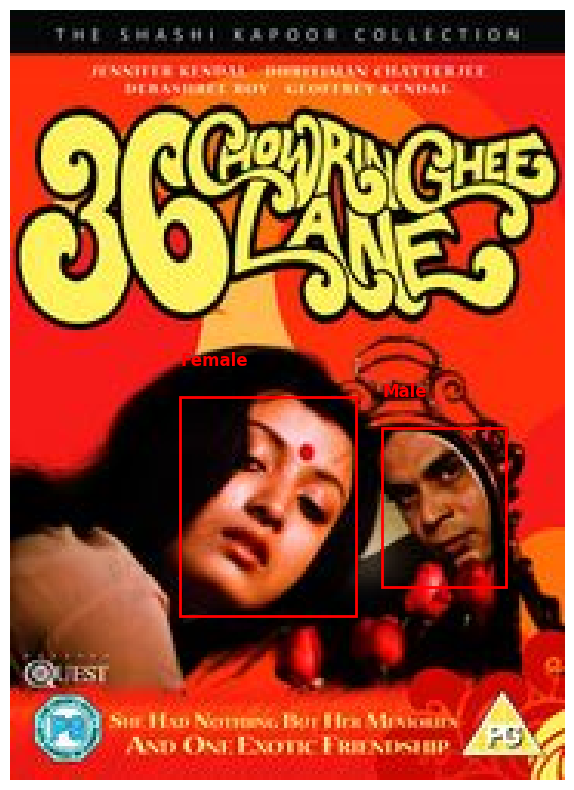

In [14]:
from facenet_pytorch import MTCNN
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Initialize MTCNN for face detection
print("Loading MTCNN model...")
mtcnn = MTCNN(keep_all=True, device='cuda' if torch.cuda.is_available() else 'cpu')
print("MTCNN model loaded.")

# Load and modify the VGG16 model for gender classification
print("Loading VGG16 model...")
vgg16_model = models.vgg16(pretrained=True)
vgg16_model.classifier[6] = nn.Linear(vgg16_model.classifier[6].in_features, 2)  # Adjust for 2 classes (Male, Female)
vgg16_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg16_model = vgg16_model.to(device)
print("VGG16 model loaded and modified for gender classification.")

# Define image transformation for VGG16 input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_image(image):
    image = transform(image)
    image = image.unsqueeze(0)
    return image.to(device)

def classify_gender(face_img):
    print("Classifying gender of the detected face...")
    face_img = preprocess_image(face_img)
    with torch.no_grad():
        outputs = vgg16_model(face_img)
        _, predicted = torch.max(outputs, 1)
    classes = ['Female', 'Male']
    gender = classes[predicted.item()]
    print(f"Predicted gender: {gender}")
    return gender

def detect_faces_mtcnn(image_path):
    print(f"Loading image from {image_path}...")
    img = Image.open(image_path).convert('RGB')
    print("Image loaded.")
    
    print("Detecting faces using MTCNN...")
    boxes, _ = mtcnn.detect(img)
    
    if boxes is None:
        print("No faces detected.")
        return
    
    print(f"Detected {len(boxes)} faces.")
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)
    
    for i, box in enumerate(boxes):
        print(f"Processing face {i + 1}...")
        face_img = img.crop((box[0], box[1], box[2], box[3]))
        gender = classify_gender(face_img)
        
        print(f"Drawing bounding box and label for face {i + 1}...")
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], edgecolor='red', facecolor='none', lw=2)
        ax.add_patch(rect)
        ax.text(box[0], box[1] - 10, gender, color='red', fontsize=12, weight='bold')
    
    print("Displaying image with detected faces and gender labels...")
    plt.axis('off')
    plt.show()

# Example usage
image_path = 'image1.jpg'  # Replace with your image path
detect_faces_mtcnn(image_path)


In [13]:
# Descriptive statistics for the number of characteristics under each gender
gender_df.describe(include='all')


,Male,Female,Neutral,Unknown
count,3030,2025,21,368
unique,1099,696,21,256
top,young,young,rural,young
freq,121,136,1,10


In [49]:
import pandas as pd
import ast

# Load the CSV file
file_path = 'female_adjverb.csv'
df = pd.read_csv(file_path, names=['Year', 'Adverbs', 'Adjectives'], on_bad_lines='skip')

# Display the first few rows of the dataframe
print("Initial DataFrame:")
print(df.head())

# Function to safely evaluate strings as lists
def safe_literal_eval(value):
    try:
        # First, clean up the string representation by removing unnecessary characters
        value = value.replace("[", "").replace("]", "").replace("'", "")
        # Then, split the string into a list
        return value.split(", ") if value else []
    except (ValueError, SyntaxError):
        return []  # Return an empty list if the value can't be parsed

# Clean the data by removing empty entries and converting string representations of lists to actual lists
df['Adverbs'] = df['Adverbs'].apply(lambda x: safe_literal_eval(x) if isinstance(x, str) else [])
df['Adjectives'] = df['Adjectives'].apply(lambda x: safe_literal_eval(x) if isinstance(x, str) else [])

# Display cleaned data
print("\nCleaned DataFrame:")
print(df.head())

# Group by year and aggregate the adverbs and adjectives
yearly_data = df.groupby('Year').agg({
    'Adverbs': lambda x: [item for sublist in x for item in sublist],
    'Adjectives': lambda x: [item for sublist in x for item in sublist]
}).reset_index()

# Display grouped data
print("\nGrouped DataFrame by Year:")
print(yearly_data.head())

# Function to count occurrences of each adverb and adjective
def count_keywords(items):
    return pd.Series(items).value_counts()

# Analyze data for each year
for index, row in yearly_data.iterrows():
    year = row['Year']
    adverbs = count_keywords(row['Adverbs'])
    adjectives = count_keywords(row['Adjectives'])
    
    print(f"\nYear: {year}")
    print(f"Top Adverbs: {adverbs}")
    print(f"Top Adjectives: {adjectives}")


Initial DataFrame:
   Year       Adverbs Adjectives
0  1970  [introduces]    [young]
1  1970     [decides]         []
2  1970       [moves]         []
3  1970       [meets]         []
4  1970            []         []

Cleaned DataFrame:
   Year       Adverbs Adjectives
0  1970  [introduces]    [young]
1  1970     [decides]         []
2  1970       [moves]         []
3  1970       [meets]         []
4  1970            []         []

Grouped DataFrame by Year:
   Year                                            Adverbs  \
0  1970  [introduces, decides, moves, meets, gets, mole...   
1  1971  [convinces, loves, finds, sees, feels, reveals...   
2  1973  [walks, tells, finds, finds, abducts, finds, s...   
3  1974  [accepts, names, accepts, finds, takes, starts...   
4  1975  [saves, passes, falls, dies, loves, wants, hel...   

                                          Adjectives  
0  [young, sister, young, adopted, poor, rich, wi...  
1  [long, young, young, blind, young, young, dece...  


Sentiment Analysis by Year:
         pos       neu       neg  Year
0   0.142857  0.785714  0.071429  1970
1   0.363636  0.636364  0.000000  1971
2   0.000000  0.909091  0.090909  1973
3   0.230769  0.769231  0.000000  1974
4   0.142857  0.857143  0.000000  1975
5   0.200000  0.800000  0.000000  1976
6   0.222222  0.777778  0.000000  1977
7   0.000000  0.800000  0.200000  1978
8   0.142857  0.857143  0.000000  1979
9   0.100000  0.900000  0.000000  1980
10  0.000000  1.000000  0.000000  1981
11  0.086957  0.913043  0.000000  1982
12  0.187500  0.812500  0.000000  1983
13  0.090909  0.727273  0.181818  1984
14  0.166667  0.750000  0.083333  1985
15  0.333333  0.666667  0.000000  1986
16  0.166667  0.833333  0.000000  1987
17  0.000000  1.000000  0.000000  1988
18  0.000000  1.000000  0.000000  1989
19  0.250000  0.625000  0.125000  1990
20  0.043478  0.869565  0.086957  1991
21  0.000000  0.764706  0.235294  1992
22  0.166667  0.750000  0.083333  1993
23  0.000000  1.000000  0.000000  1

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sneha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


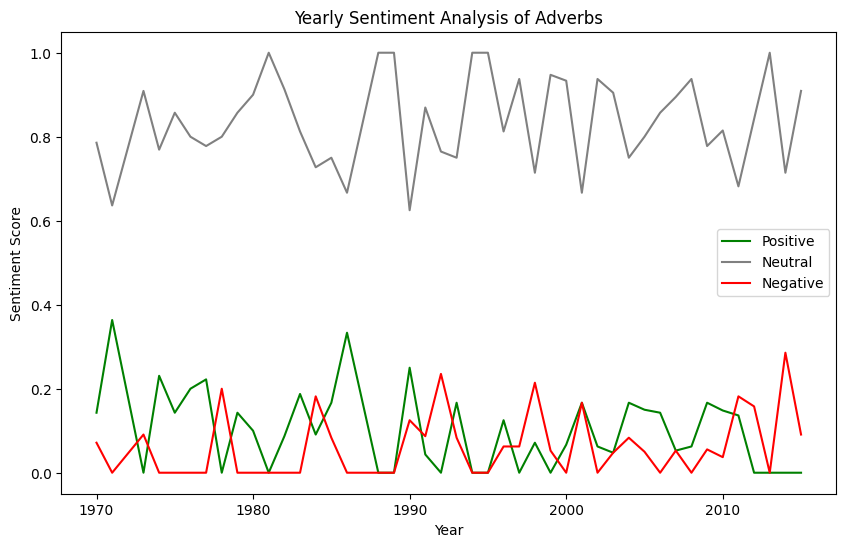

In [50]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon if not already available
nltk.download('vader_lexicon')

# Load the CSV file
file_path = 'female_adjverb.csv'
df = pd.read_csv(file_path, names=['Year', 'Adverbs', 'Adjectives'], on_bad_lines='skip')

# Function to safely evaluate strings as lists
def safe_literal_eval(value):
    try:
        value = value.replace("[", "").replace("]", "").replace("'", "")
        return value.split(", ") if value else []
    except (ValueError, SyntaxError):
        return []

# Clean the data by removing empty entries and converting string representations of lists to actual lists
df['Adverbs'] = df['Adverbs'].apply(lambda x: safe_literal_eval(x) if isinstance(x, str) else [])
df['Adjectives'] = df['Adjectives'].apply(lambda x: safe_literal_eval(x) if isinstance(x, str) else [])

# Group by year and aggregate the adverbs and adjectives
yearly_data = df.groupby('Year').agg({
    'Adverbs': lambda x: [item for sublist in x for item in sublist],
    'Adjectives': lambda x: [item for sublist in x for item in sublist]
}).reset_index()

# Initialize the sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment for a list of words
def calculate_sentiment(words):
    scores = {'pos': 0, 'neu': 0, 'neg': 0}
    for word in words:
        sentiment = sia.polarity_scores(word)
        scores['pos'] += sentiment['pos']
        scores['neu'] += sentiment['neu']
        scores['neg'] += sentiment['neg']
    total = scores['pos'] + scores['neu'] + scores['neg']
    if total > 0:
        scores = {key: value / total for key, value in scores.items()}
    return scores

# Analyze sentiment for each year
sentiment_data = []
for index, row in yearly_data.iterrows():
    year = row['Year']
    adverbs = row['Adverbs']
    sentiment = calculate_sentiment(adverbs)
    sentiment['Year'] = year
    sentiment_data.append(sentiment)

# Create a DataFrame to store sentiment analysis results
sentiment_df = pd.DataFrame(sentiment_data)

# Display the sentiment analysis results
print("\nSentiment Analysis by Year:")
print(sentiment_df)

# Optional: Visualize the sentiment analysis results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(sentiment_df['Year'], sentiment_df['pos'], label='Positive', color='green')
plt.plot(sentiment_df['Year'], sentiment_df['neu'], label='Neutral', color='gray')
plt.plot(sentiment_df['Year'], sentiment_df['neg'], label='Negative', color='red')
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.title('Yearly Sentiment Analysis of Adverbs')
plt.legend()
plt.show()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sneha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



Sentiment Analysis by Year:
         pos       neu       neg  Year
0   0.142857  0.785714  0.071429  1970
1   0.363636  0.636364  0.000000  1971
2   0.000000  0.909091  0.090909  1973
3   0.230769  0.769231  0.000000  1974
4   0.142857  0.857143  0.000000  1975
5   0.200000  0.800000  0.000000  1976
6   0.222222  0.777778  0.000000  1977
7   0.000000  0.800000  0.200000  1978
8   0.142857  0.857143  0.000000  1979
9   0.100000  0.900000  0.000000  1980
10  0.000000  1.000000  0.000000  1981
11  0.086957  0.913043  0.000000  1982
12  0.187500  0.812500  0.000000  1983
13  0.090909  0.727273  0.181818  1984
14  0.166667  0.750000  0.083333  1985
15  0.333333  0.666667  0.000000  1986
16  0.166667  0.833333  0.000000  1987
17  0.000000  1.000000  0.000000  1988
18  0.000000  1.000000  0.000000  1989
19  0.250000  0.625000  0.125000  1990
20  0.043478  0.869565  0.086957  1991
21  0.000000  0.764706  0.235294  1992
22  0.166667  0.750000  0.083333  1993
23  0.000000  1.000000  0.000000  1

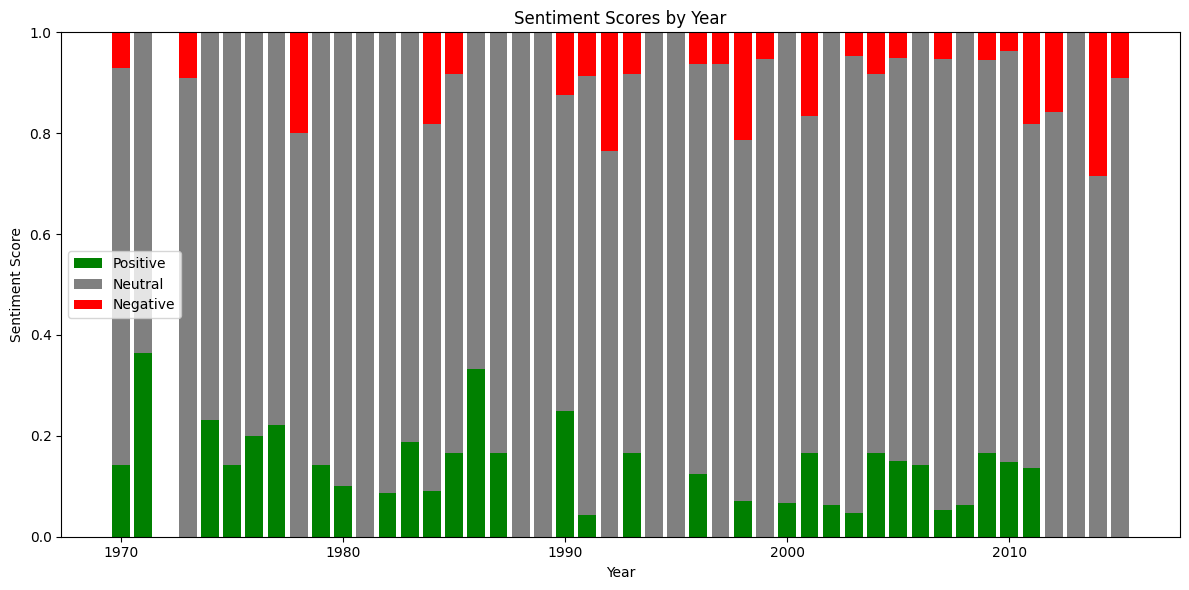

In [70]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt

# Download VADER lexicon if not already available
nltk.download('vader_lexicon')

# Load the CSV file
file_path = 'female_adjverb.csv'
df = pd.read_csv(file_path, names=['Year', 'Adverbs', 'Adjectives'], on_bad_lines='skip')

# Function to safely evaluate strings as lists
def safe_literal_eval(value):
    try:
        value = value.replace("[", "").replace("]", "").replace("'", "")
        return value.split(", ") if value else []
    except (ValueError, SyntaxError):
        return []

# Clean the data by removing empty entries and converting string representations of lists to actual lists
df['Adverbs'] = df['Adverbs'].apply(lambda x: safe_literal_eval(x) if isinstance(x, str) else [])
df['Adjectives'] = df['Adjectives'].apply(lambda x: safe_literal_eval(x) if isinstance(x, str) else [])

# Group by year and aggregate the adverbs and adjectives
yearly_data = df.groupby('Year').agg({
    'Adverbs': lambda x: [item for sublist in x for item in sublist],
    'Adjectives': lambda x: [item for sublist in x for item in sublist]
}).reset_index()

# Initialize the sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment for a list of words
def calculate_sentiment(words):
    scores = {'pos': 0, 'neu': 0, 'neg': 0}
    for word in words:
        sentiment = sia.polarity_scores(word)
        scores['pos'] += sentiment['pos']
        scores['neu'] += sentiment['neu']
        scores['neg'] += sentiment['neg']
    total = scores['pos'] + scores['neu'] + scores['neg']
    if total > 0:
        scores = {key: value / total for key, value in scores.items()}
    return scores

# Analyze sentiment for each year
sentiment_data = []
for index, row in yearly_data.iterrows():
    year = row['Year']
    adverbs = row['Adverbs']
    sentiment = calculate_sentiment(adverbs)
    sentiment['Year'] = year
    sentiment_data.append(sentiment)

# Create a DataFrame to store sentiment analysis results
sentiment_df = pd.DataFrame(sentiment_data)

# Display the sentiment analysis results
print("\nSentiment Analysis by Year:")
print(sentiment_df)

# Plot stacked histogram for sentiment scores by year
plt.figure(figsize=(12, 6))

# Stacked histogram for all sentiment scores
plt.bar(sentiment_df['Year'], sentiment_df['pos'], color='green', label='Positive')
plt.bar(sentiment_df['Year'], sentiment_df['neu'], bottom=sentiment_df['pos'], color='gray', label='Neutral')
plt.bar(sentiment_df['Year'], sentiment_df['neg'], bottom=sentiment_df['pos'] + sentiment_df['neu'], color='red', label='Negative')

plt.title('Sentiment Scores by Year')
plt.ylabel('Sentiment Score')
plt.xlabel('Year')
plt.legend()
plt.tight_layout()
plt.show()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sneha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



Sentiment Analysis by Year:
         pos       neu       neg  Year
0   0.076923  0.923077  0.000000  1970
1   0.032258  0.935484  0.032258  1971
2   0.000000  1.000000  0.000000  1973
3   0.000000  0.866667  0.133333  1974
4   0.066667  0.866667  0.066667  1975
5   0.058824  0.882353  0.058824  1976
6   0.000000  0.931034  0.068966  1977
7   0.166667  0.833333  0.000000  1978
8   0.200000  0.600000  0.200000  1979
9   0.041667  0.875000  0.083333  1980
10  0.055556  0.722222  0.222222  1981
11  0.000000  0.814815  0.185185  1982
12  0.000000  0.923077  0.076923  1983
13  0.040000  0.920000  0.040000  1984
14  0.040000  0.920000  0.040000  1985
15  0.400000  0.400000  0.200000  1986
16  0.052632  0.842105  0.105263  1987
17  0.176471  0.352941  0.470588  1988
18  0.000000  0.882353  0.117647  1989
19  0.041667  0.791667  0.166667  1990
20  0.096774  0.774194  0.129032  1991
21  0.025641  0.948718  0.025641  1992
22  0.037037  0.888889  0.074074  1993
23  0.333333  0.666667  0.000000  1

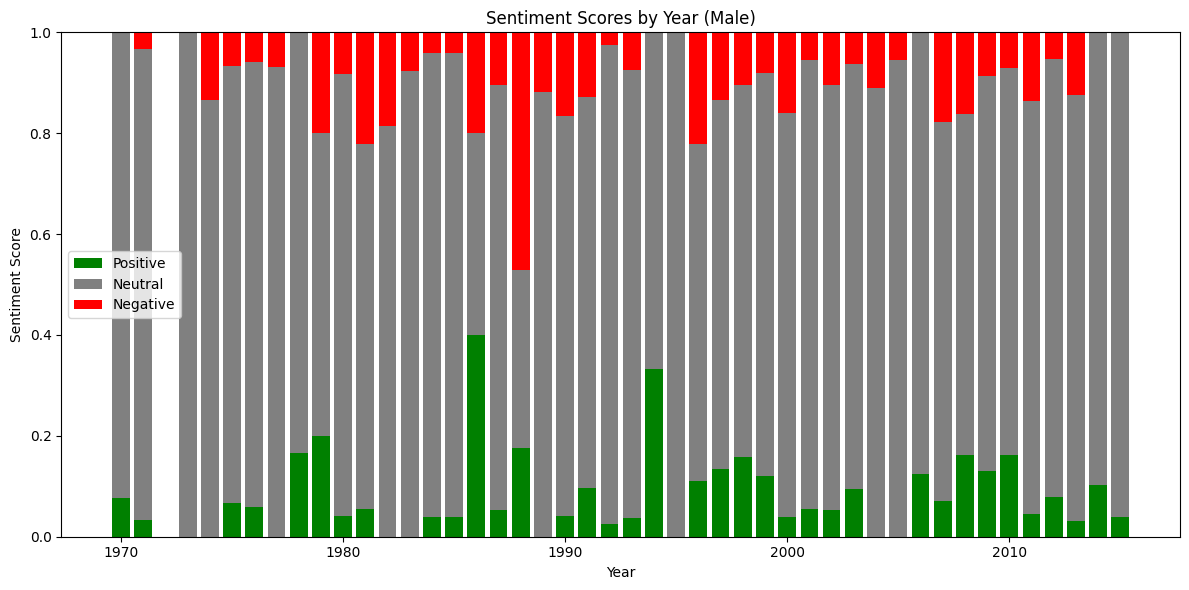

In [69]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt

# Download VADER lexicon if not already available
nltk.download('vader_lexicon')

# Load the CSV file
file_path = 'male_adjverb.csv'
df = pd.read_csv(file_path, names=['Year', 'Adverbs', 'Adjectives'], on_bad_lines='skip')

# Function to safely evaluate strings as lists
def safe_literal_eval(value):
    try:
        value = value.replace("[", "").replace("]", "").replace("'", "")
        return value.split(", ") if value else []
    except (ValueError, SyntaxError):
        return []

# Clean the data by removing empty entries and converting string representations of lists to actual lists
df['Adverbs'] = df['Adverbs'].apply(lambda x: safe_literal_eval(x) if isinstance(x, str) else [])
df['Adjectives'] = df['Adjectives'].apply(lambda x: safe_literal_eval(x) if isinstance(x, str) else [])

# Group by year and aggregate the adverbs and adjectives
yearly_data = df.groupby('Year').agg({
    'Adverbs': lambda x: [item for sublist in x for item in sublist],
    'Adjectives': lambda x: [item for sublist in x for item in sublist]
}).reset_index()

# Initialize the sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment for a list of words
def calculate_sentiment(words):
    scores = {'pos': 0, 'neu': 0, 'neg': 0}
    for word in words:
        sentiment = sia.polarity_scores(word)
        scores['pos'] += sentiment['pos']
        scores['neu'] += sentiment['neu']
        scores['neg'] += sentiment['neg']
    total = scores['pos'] + scores['neu'] + scores['neg']
    if total > 0:
        scores = {key: value / total for key, value in scores.items()}
    return scores

# Analyze sentiment for each year
sentiment_data = []
for index, row in yearly_data.iterrows():
    year = row['Year']
    adverbs = row['Adverbs']
    sentiment = calculate_sentiment(adverbs)
    sentiment['Year'] = year
    sentiment_data.append(sentiment)

# Create a DataFrame to store sentiment analysis results
sentiment_df1 = pd.DataFrame(sentiment_data)

# Display the sentiment analysis results
print("\nSentiment Analysis by Year:")
print(sentiment_df1)

# Plot stacked histogram for sentiment scores by year
plt.figure(figsize=(12, 6))

# Stacked histogram for all sentiment scores
plt.bar(sentiment_df1['Year'], sentiment_df1['pos'], color='green', label='Positive')
plt.bar(sentiment_df1['Year'], sentiment_df1['neu'], bottom=sentiment_df1['pos'], color='gray', label='Neutral')
plt.bar(sentiment_df1['Year'], sentiment_df1['neg'], bottom=sentiment_df1['pos'] + sentiment_df1['neu'], color='red', label='Negative')

plt.title('Sentiment Scores by Year (Male)')
plt.ylabel('Sentiment Score')
plt.xlabel('Year')
plt.legend()
plt.tight_layout()
plt.show()


In [88]:
yearly_data

,YEAR,MALE SONG COUNT,FEMALE SONG COUNT
0,1970,188.0,229.0
1,1971,325.0,406.0
2,1972,237.0,261.0
3,1973,227.0,310.0
4,1974,197.0,245.0
5,1975,189.0,219.0
6,1976,211.0,213.0
7,1977,342.0,367.0
8,1978,164.0,191.0
9,1979,201.0,228.0


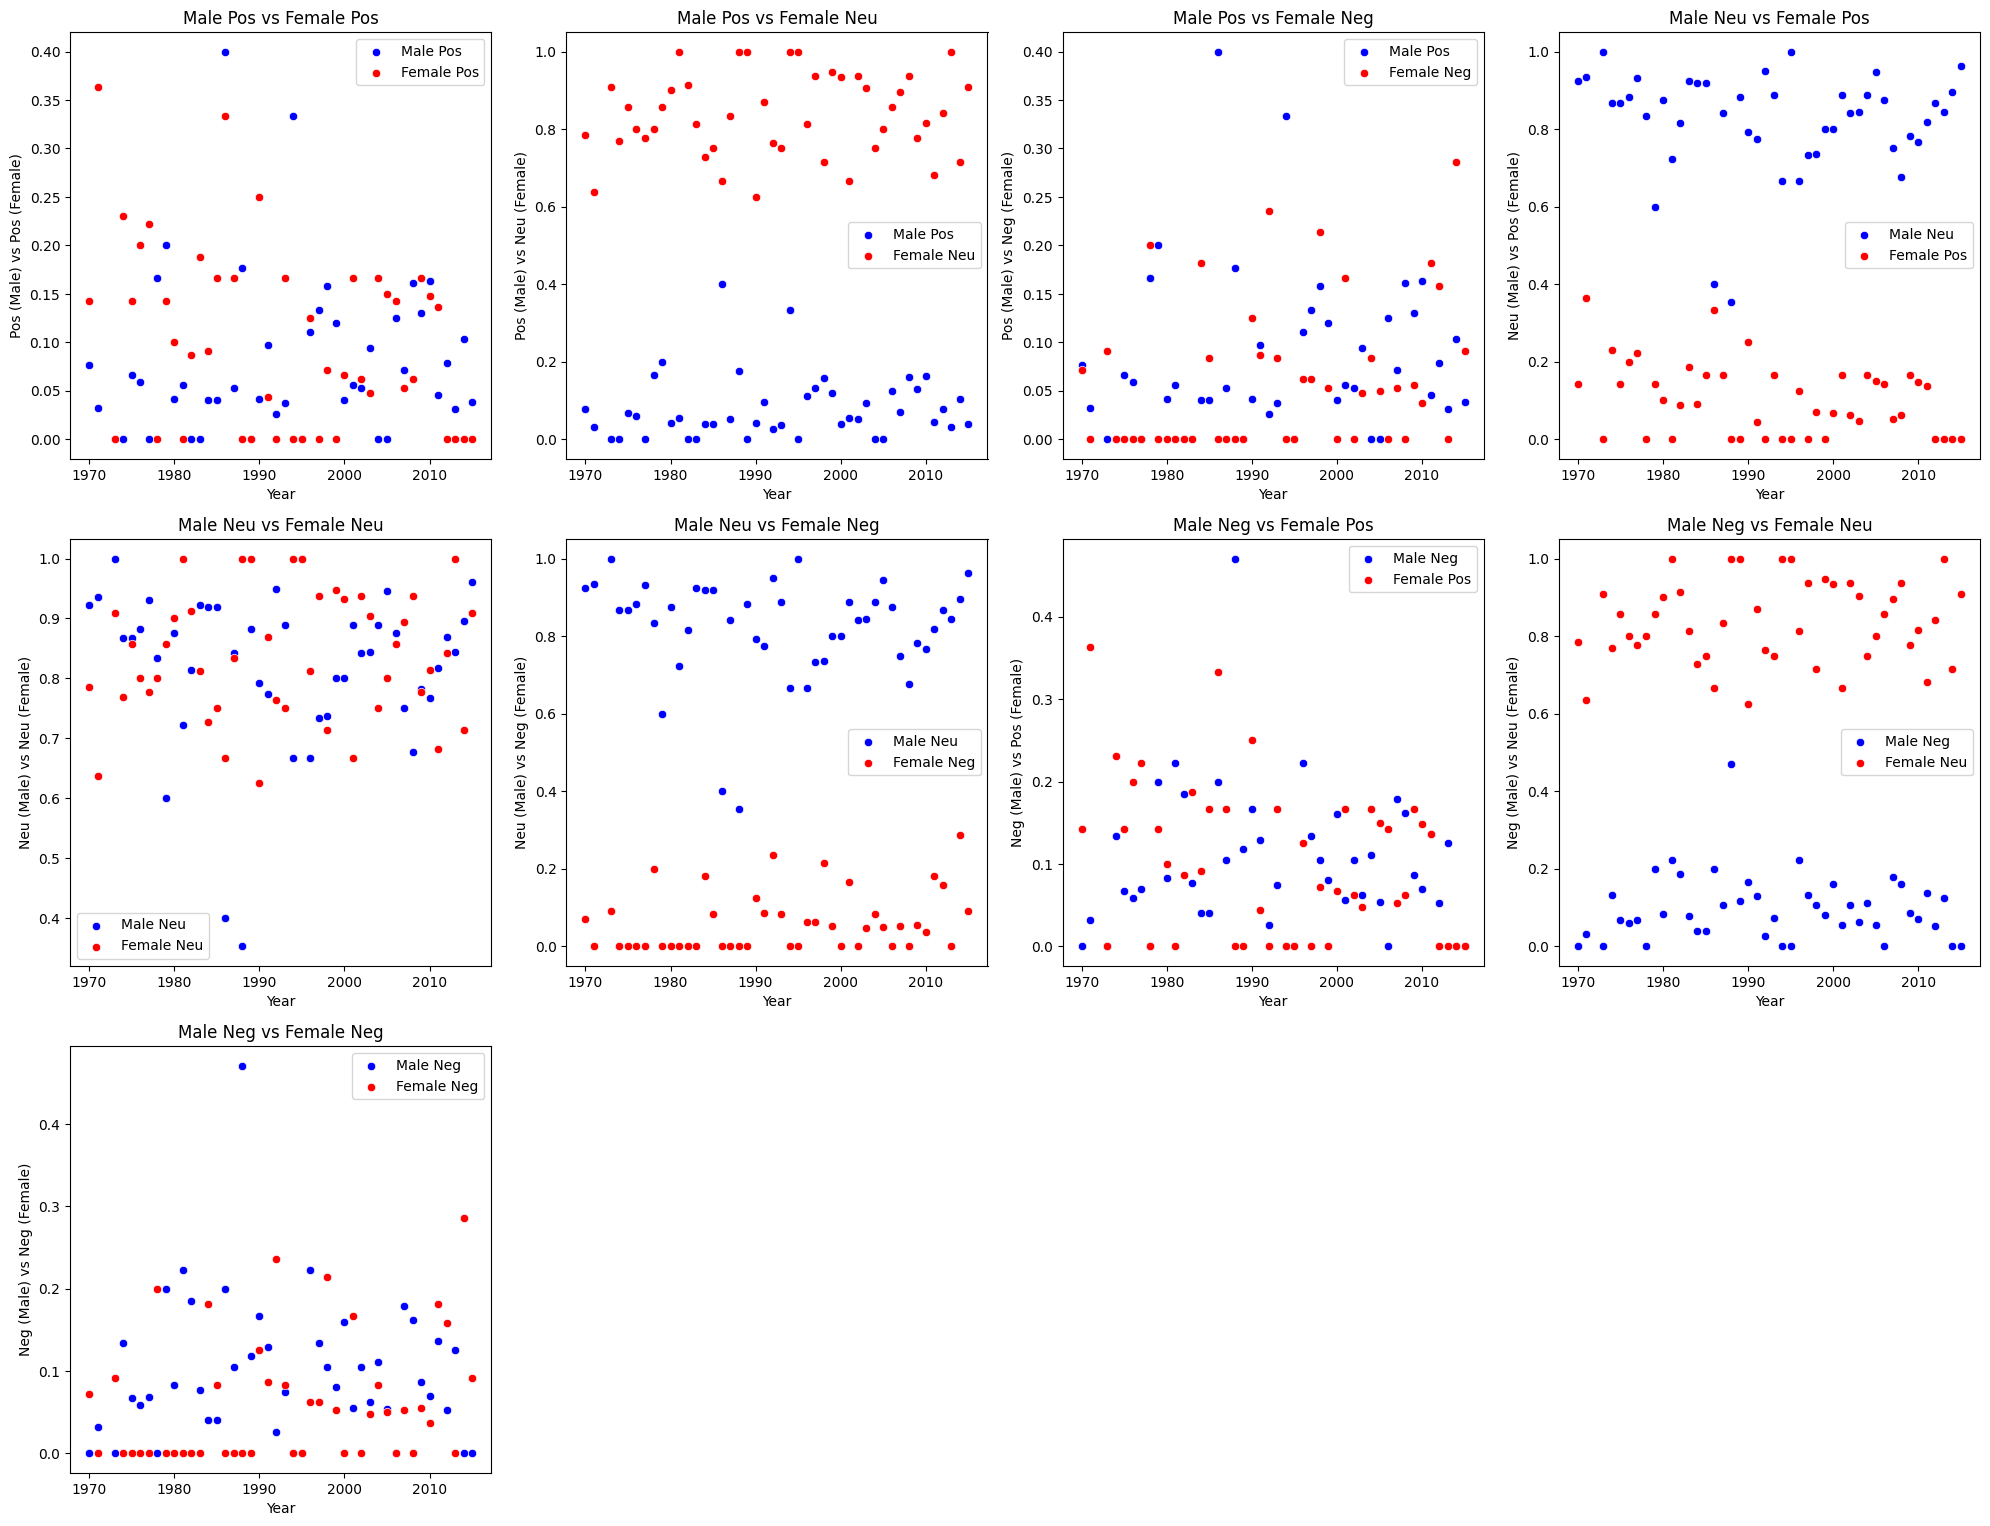

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Define the possible sentiment features
sentiment_features = ['pos', 'neu', 'neg']

# Generate all possible combinations of male and female sentiment features
gender_combinations = list(itertools.product(sentiment_features, repeat=2))

# Set up the plotting environment with a dynamic grid size
num_combinations = len(gender_combinations)
grid_size = int(num_combinations**0.5) + 1

plt.figure(figsize=(20, 20))

# Loop through the combinations and create the plots
for i, (male_feature, female_feature) in enumerate(gender_combinations, 1):
    plt.subplot(grid_size, grid_size, i)
    sns.scatterplot(data=sentiment_df1, x='Year', y=male_feature, color='blue', label=f'Male {male_feature.capitalize()}')
    sns.scatterplot(data=sentiment_df, x='Year', y=female_feature, color='red', label=f'Female {female_feature.capitalize()}')
    plt.xlabel('Year')
    plt.ylabel(f'{male_feature.capitalize()} (Male) vs {female_feature.capitalize()} (Female)')
    plt.title(f'Male {male_feature.capitalize()} vs Female {female_feature.capitalize()}')
    plt.legend()

plt.tight_layout()
plt.show()


In [110]:
import pandas as pd


# Ensure the YEAR column is properly formatted as an integer
def clean_year_column(df, column_name):
    if column_name in df.columns:
        df[column_name] = df[column_name].astype(str).str.strip()  # Ensure all data is string then strip spaces
        df[column_name] = pd.to_numeric(df[column_name], errors='coerce')  # Convert to numeric, coercing errors to NaN
        df = df.dropna(subset=[column_name])  # Drop rows with NaN in the YEAR column
        df[column_name] = df[column_name].astype(int)  # Convert to int
        return df
    else:
        raise KeyError(f"The column '{column_name}' does not exist in the DataFrame.")

# Clean the YEAR columns in each dataframe
yearly_data = clean_year_column(yearly_data, 'YEAR')
sentiment_df = clean_year_column(sentiment_df.rename(columns={"Year": "YEAR"}), 'YEAR')
sentiment_df1 = clean_year_column(sentiment_df1.rename(columns={"Year": "YEAR"}), 'YEAR')

# Merge the sentiment data with the yearly_data on 'YEAR'
combined_df = pd.merge(yearly_data, sentiment_df[['YEAR', 'pos']], on='YEAR', how='left')
combined_df = pd.merge(combined_df, sentiment_df1[['YEAR', 'pos']], on='YEAR', how='left', suffixes=('_female', '_male'))

# Initialize lists to store results
consistent_results = []
inconsistent_results = []
t=[]
f=[]
# Loop through each year and analyze the conditions
for index, row in combined_df.iterrows():
    year = row['YEAR']
    female_pos = row['pos_female']
    male_pos = row['pos_male']
    female_song_count = row['FEMALE SONG COUNT']
    male_song_count = row['MALE SONG COUNT']
    
    
    if  female_song_count > male_song_count:
            consistent_results.append(year)
    if female_pos >=male_pos :
            inconsistent_results.append(year)
    if male_pos> female_pos:        #and male_song_count > female_song_count
            t.append(year)
   # elif male_pos <= female_pos and male_song_count <= female_song_count:
   #         inconsistent_results.append(year)'''
    if female_pos ==0 :
             f.append(year)
# Display results
print("Consistent years:", consistent_results)
print("Inconsistent years:", inconsistent_results)
print('t',t)
print('f:',f)

Consistent years: [1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 2001.0]
Inconsistent years: [1970.0, 1971.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1980.0, 1982.0, 1983.0, 1984.0, 1985.0, 1987.0, 1989.0, 1990.0, 1993.0, 1995.0, 1996.0, 2000.0, 2001.0, 2009.0, 2011.0]
t [1978.0, 1979.0, 1981.0, 1986.0, 1988.0, 1991.0, 1992.0, 1994.0, 1997.0, 1998.0, 1999.0, 2007.0, 2010.0, 2012.0, 2013.0, 2014.0, 2015.0]
f: [1973.0, 1978.0, 1981.0, 1988.0, 1989.0, 1992.0, 1994.0, 1995.0, 1997.0, 1999.0, 2012.0, 2013.0, 2014.0, 2015.0]


In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file

df = pd.read_csv('complete-data.csv')

# Group by movie_name, gender, and emotion
grouped_df = df.groupby(['movie_name', 'gender', 'emotion']).size().reset_index(name='count')

# Pivot the table to get emotions as columns
pivot_df = grouped_df.pivot_table(index=['movie_name', 'gender'], columns='emotion', values='count', fill_value=0).reset_index()

# Calculate sentiment scores
# Assuming simple sentiment scores: positive for 'happy', negative for 'sad', 'angry', neutral for 'neutral'
pivot_df['positive'] = pivot_df.get('happy', 0)
pivot_df['negative'] = pivot_df.get('sad', 0) + pivot_df.get('angry', 0)
pivot_df['neutral'] = pivot_df.get('neutral', 0)

# Normalize the scores
pivot_df['total'] = pivot_df['positive'] + pivot_df['negative'] + pivot_df['neutral']
pivot_df['pos_score'] = pivot_df['positive'] / pivot_df['total']
pivot_df['neg_score'] = pivot_df['negative'] / pivot_df['total']
pivot_df['neu_score'] = pivot_df['neutral'] / pivot_df['total']

# Drop unnecessary columns
pivot_df = pivot_df.drop(columns=['positive', 'negative', 'neutral', 'total'])

# Display the result
print(pivot_df.head(100))
print(pivot_df.columns)

# Example: Plotting the sentiment analysis for each movie
'''plt.figure(figsize=(12, 6))
sns.barplot(x='movie_name', y='pos_score', hue='gender', data=pivot_df)
plt.title('Positive Sentiment Score by Gender for Each Movie')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='movie_name', y='neg_score', hue='gender', data=pivot_df)
plt.title('Negative Sentiment Score by Gender for Each Movie')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='movie_name', y='neu_score', hue='gender', data=pivot_df)
plt.title('Neutral Sentiment Score by Gender for Each Movie')
plt.xticks(rotation=45)
plt.show()'''


emotion                movie_name gender  angry  disgust  fear  happy   sad  \
0                     102_not_out    man   17.0      1.0   2.0    6.0  22.0   
1                     102_not_out  woman    0.0      0.0   3.0    4.0   5.0   
2                            1920    man    2.0      0.0   1.0    0.0   0.0   
3                     1920_london    man    1.0      1.0   0.0    0.0   4.0   
4                     1920_london  woman    0.0      0.0   1.0    0.0   3.0   
..                            ...    ...    ...      ...   ...    ...   ...   
95       all_the_best:_fun_begins  woman    0.0      0.0   0.0    0.0   0.0   
96                          alone    man    3.0      0.0   5.0    4.0   2.0   
97                          alone  woman    0.0      0.0   2.0    4.0   1.0   
98             always_kabhi_kabhi    man   11.0      0.0   5.0   12.0   7.0   
99             always_kabhi_kabhi  woman    2.0      0.0   0.0    5.0   9.0   

emotion  surprise  pos_score  neg_score  neu_score 

"plt.figure(figsize=(12, 6))\nsns.barplot(x='movie_name', y='pos_score', hue='gender', data=pivot_df)\nplt.title('Positive Sentiment Score by Gender for Each Movie')\nplt.xticks(rotation=45)\nplt.show()\n\nplt.figure(figsize=(12, 6))\nsns.barplot(x='movie_name', y='neg_score', hue='gender', data=pivot_df)\nplt.title('Negative Sentiment Score by Gender for Each Movie')\nplt.xticks(rotation=45)\nplt.show()\n\nplt.figure(figsize=(12, 6))\nsns.barplot(x='movie_name', y='neu_score', hue='gender', data=pivot_df)\nplt.title('Neutral Sentiment Score by Gender for Each Movie')\nplt.xticks(rotation=45)\nplt.show()"

In [123]:
import pandas as pd

# Assuming your CSV data is already loaded in a dataframe named df

# Group by movie_name and gender, then sum the counts of emotions
emotion_count = df.groupby(['movie_name', 'gender']).size().reset_index(name='emotion_count')

# Display the result
display(emotion_count)


,movie_name,gender,emotion_count
0,102_not_out,man,69
1,102_not_out,woman,19
2,1920,man,3
3,1920_london,man,8
4,1920_london,woman,6
...,...,...,...
1659,zokkomon,woman,6
1660,zor_lagaa_ke,man,21
1661,zor_lagaa_ke,woman,10
1662,zubaan,man,17


In [128]:
# Initialize lists to store the categorized movies
female_dominant_movies = []
male_dominant_movies = []
neutral_movies = []

# Group by movie_name to compare emotion counts between male and female
grouped = emotion_count.groupby('movie_name')

for movie, data in grouped:
    male_count = data[data['gender'] == 'man']['emotion_count'].sum()
    female_count = data[data['gender'] == 'woman']['emotion_count'].sum()
    
    if female_count > male_count:
        female_dominant_movies.append(movie)
    elif male_count > female_count:
        male_dominant_movies.append(movie)
    else:
        neutral_movies.append(movie)

# Display the categorized lists
print("Female Dominant Movies:", female_dominant_movies)
print("Male Dominant Movies:", male_dominant_movies)
print("Neutral Movies:", neutral_movies)


Female Dominant Movies: ['?_:_a_question_mark', 'aashiqui_2', 'accident_on_hill_road', 'anaarkali_of_aarah', 'anamika', 'angry_indian_goddesses', 'apartment_2', 'babu_ji_ek_ticket_bambai', 'bachna_ae_haseeno', 'badmashiyaan', 'bal_ganesh_2', 'band_baaja_baaraat', 'beiimaan_love', 'bobby_jasoos', 'break_ke_baad', 'bubble_gum', 'calender_girls', 'chalk_n_duster', 'dangerous_ishq', 'dhanak', 'dil_bole_hadippa!', 'dil_toh_deewana_hai', 'dolly_ki_doli', 'ek_kahani_julie_ki', 'ek_vivaah', 'fitoor', 'gippi', 'gulaab_gang', 'gulabi_gang', "hanuman:_da'_damdaar", 'haramkhor', 'heroine', 'ishq_junoon', 'island_city', 'jai_gangaajal', 'jalpari:_the_desert_mermaid', 'kambakkht_ishq', 'khoobsurat', 'kuch_kuch_locha_hai', 'kya_kool_hain_hum_3', 'laali_ki_shaadi_mein_laaddoo_deewana', 'ladies_vs_ricky_bahl', 'lakshmi', 'lekar_hum_deewana_dil', 'life_mein_twist_hai', 'love_aaj_kal', 'love_games', 'luckhnowi_ishq', 'maatr', 'machine', 'main_krishna_hoon', 'margarita_with_a_straw', 'masuam', 'meerbai_no

In [136]:
import pandas as pd

# Load the CSV files
male_centrality = pd.read_csv('male_centrality.csv')
female_centrality = pd.read_csv('female_centrality.csv')

# Trim whitespace from column names
male_centrality.columns = male_centrality.columns.str.strip()
female_centrality.columns = female_centrality.columns.str.strip()

# Check the cleaned column names
print("Cleaned Male Centrality Columns:", male_centrality.columns)
print("Cleaned Female Centrality Columns:", female_centrality.columns)

# Group by Movie Name and sum the Total Centrality and calculate the mean of Average Centrality
male_agg = male_centrality.groupby('Movie Name').agg({
    'Total Centrality': 'sum',
    'Average Centrality': 'mean'
}).rename(columns={'Total Centrality': 'Male Total Centrality', 'Average Centrality': 'Male Average Centrality'})

female_agg = female_centrality.groupby('Movie Name').agg({
    'Total Centrality': 'sum',
    'Average Centrality': 'mean'
}).rename(columns={'Total Centrality': 'Female Total Centrality', 'Average Centrality': 'Female Average Centrality'})

# Merge the male and female dataframes on Movie Name
dominance_df = pd.merge(male_agg, female_agg, on='Movie Name', how='outer').fillna(0)

# Determine dominance
dominance_df['Dominance'] = dominance_df.apply(
    lambda row: 'Male' if row['Male Total Centrality'] > row['Female Total Centrality'] else 'Female', axis=1
)

# Show the final dataframe with dominance
print(dominance_df[['Male Total Centrality', 'Female Total Centrality', 'Dominance']])


Cleaned Male Centrality Columns: Index(['Movie Name', 'Cast Name', 'Total Centrality', 'Average Centrality'], dtype='object')
Cleaned Female Centrality Columns: Index(['Movie Name', 'Cast Name', 'Total Centrality', 'Average Centrality'], dtype='object')
                         Male Total Centrality  Female Total Centrality  \
Movie Name                                                                
100 Days                            382.500000              2176.600000   
13B                                 326.500000               222.866667   
16 December                        4477.583333                 0.000000   
1920                                458.333333               516.833333   
1920 London                        2729.300000              1852.366667   
...                                        ...                      ...   
United Six                            0.000000               313.666667   
Uphaar                                0.000000              3087.955556